In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox

# read csv into dataframe
df_all = pd.read_csv("df_all.csv")

In [ ]:
# change columns to numerics
print(df_all.dtypes)
numeric_cols = [
    "channels_in", "channels_out", "channels_unknown", "channels_all", 
    "site_temperature", "site_rain_accumulation", "site_snow_accumulation"]

df_all[numeric_cols] = df_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

operator_name              object
domain_name                object
domain_id                   int64
counter_site               object
counter_site_id             int64
counter_serial             object
longitude                 float64
latitude                  float64
timezone                   object
iso_timestamp              object
channels_in               float64
channels_out              float64
channels_unknown          float64
channels_all                int64
site_temperature          float64
site_rain_accumulation    float64
site_snow_accumulation    float64
day                        object
dtype: object


In [ ]:
# subset of dataframe just for tübi
df_tue = df_all[df_all["domain_name"] == "Stadt Tübingen"]
df_tue = df_tue.groupby("counter_site")

# get coordinates for every counter site in tüb
tue_coords = {
    name: (
        df_tue.get_group(name)["latitude"].iloc[0],
        df_tue.get_group(name)["longitude"].iloc[0]
    )
    for name in df_tue.groups.keys()
}
tue_coords

{'Fuß- & Radtunnel Südportal - Derendinger Allee': (np.float64(48.518),
  np.float64(9.04806)),
 'Neckartalradweg Hirschau - parallel L371': (np.float64(48.50357),
  np.float64(9.02496)),
 'Radbrücke Mitte - Wöhrdstraße': (np.float64(48.5178), np.float64(9.06091)),
 'Radbrücke Ost': (np.float64(48.51824), np.float64(9.06905)),
 'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee': (np.float64(48.515434),
  np.float64(9.058865))}

In [ ]:
# set some coords as center point, e.g. fahrradtunnel
center_point = (48.518, 9.048)  

# access streetmaps graph with bike lanes, with radtunnel as cp and 3km radius
G = ox.graph_from_point(center_point, dist=3000, network_type='bike')

In [ ]:
# nodes in our graph are our 5 counter sites 
snapped_nodes = {}
for name, (lat, lon) in tue_coords.items():
    node = ox.distance.nearest_nodes(G, X=lon, Y=lat)
    snapped_nodes[name] = node

In [ ]:
# now name the nodes and compute shortest distance by bike
import networkx as nx
u = snapped_nodes['Fuß- & Radtunnel Südportal - Derendinger Allee']
v = snapped_nodes['Radbrücke Ost']
w = snapped_nodes['Neckartalradweg Hirschau - parallel L371']
x = snapped_nodes['Radbrücke Mitte - Wöhrdstraße']
y = snapped_nodes['Unterführung Steinlach/Karlstraße Südseite - Steinlachallee']

distance_uv = nx.shortest_path_length(G, u, v, weight='length')
distance_uw = nx.shortest_path_length(G, u, w, weight='length')
distance_ux = nx.shortest_path_length(G, u, x, weight='length')
distance_uy = nx.shortest_path_length(G, u, y, weight='length')
distance_vw = nx.shortest_path_length(G, v, w, weight='length')
distance_vx = nx.shortest_path_length(G, v, x, weight='length')
distance_vy = nx.shortest_path_length(G, v, y, weight='length')
distance_wx = nx.shortest_path_length(G, w, x, weight='length')
distance_wy = nx.shortest_path_length(G, w, y, weight='length')
distance_xy = nx.shortest_path_length(G, x, y, weight='length')
print(f"Fahrrad-Distanz: {distance_uv:.1f} m")
print(f"Fahrrad-Distanz: {distance_uw:.1f} m")
print(f"Fahrrad-Distanz: {distance_ux:.1f} m")
print(f"Fahrrad-Distanz: {distance_uy:.1f} m")
print(f"Fahrrad-Distanz: {distance_vw:.1f} m")
print(f"Fahrrad-Distanz: {distance_vx:.1f} m")
print(f"Fahrrad-Distanz: {distance_vy:.1f} m")
print(f"Fahrrad-Distanz: {distance_wx:.1f} m")
print(f"Fahrrad-Distanz: {distance_wy:.1f} m")
print(f"Fahrrad-Distanz: {distance_xy:.1f} m")

Fahrrad-Distanz: 1906.1 m
Fahrrad-Distanz: 2521.1 m
Fahrrad-Distanz: 1142.7 m
Fahrrad-Distanz: 1353.0 m
Fahrrad-Distanz: 4373.7 m
Fahrrad-Distanz: 798.3 m
Fahrrad-Distanz: 1136.4 m
Fahrrad-Distanz: 3613.8 m
Fahrrad-Distanz: 3748.0 m
Fahrrad-Distanz: 479.2 m


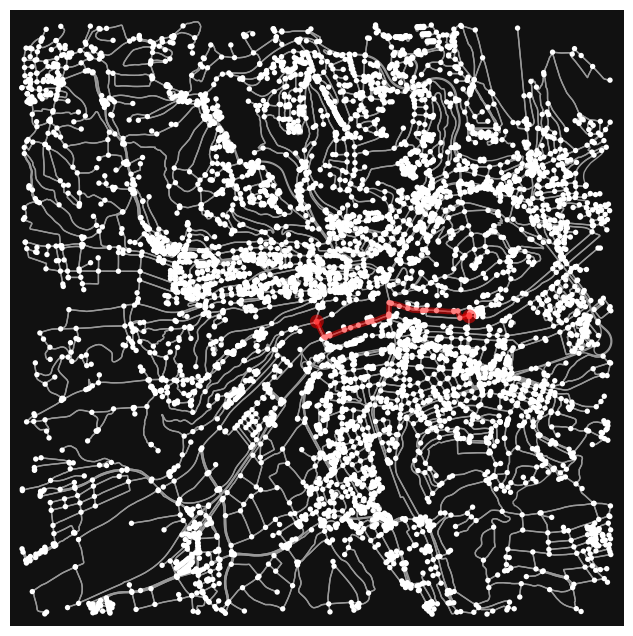

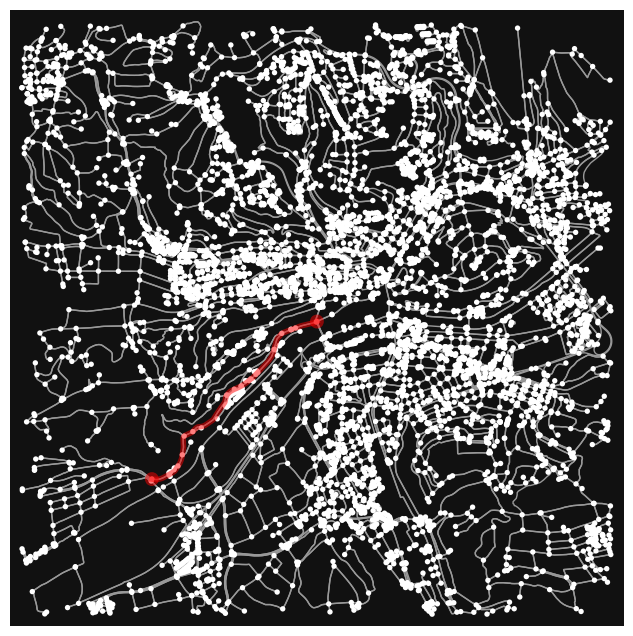

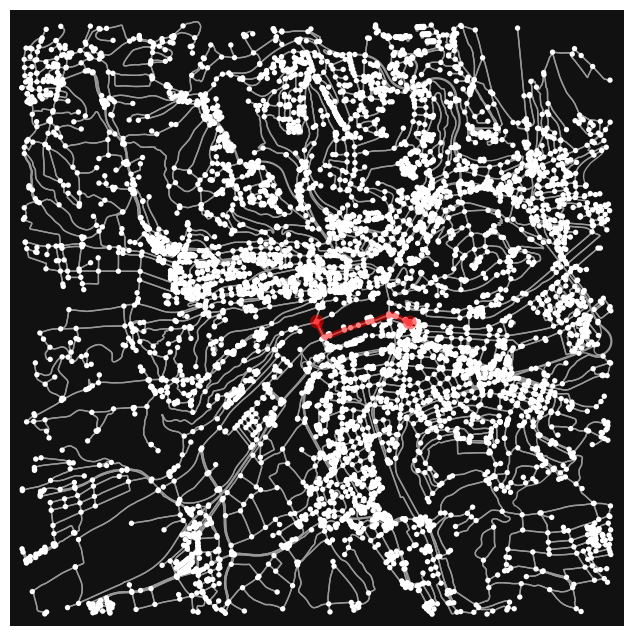

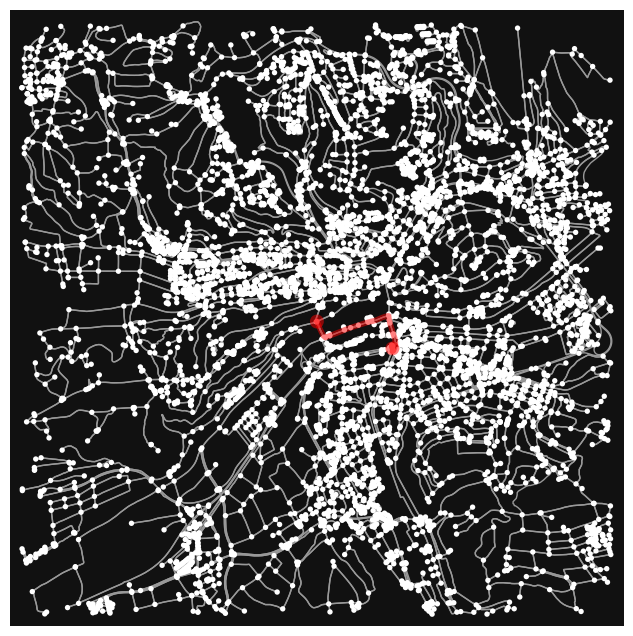

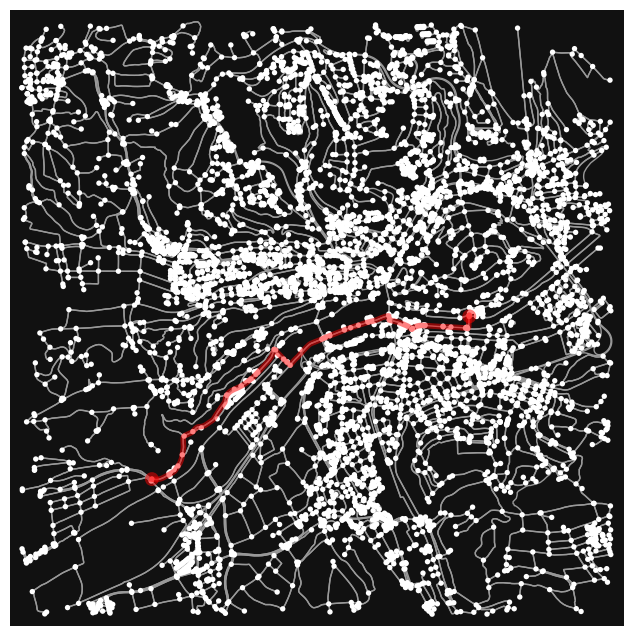

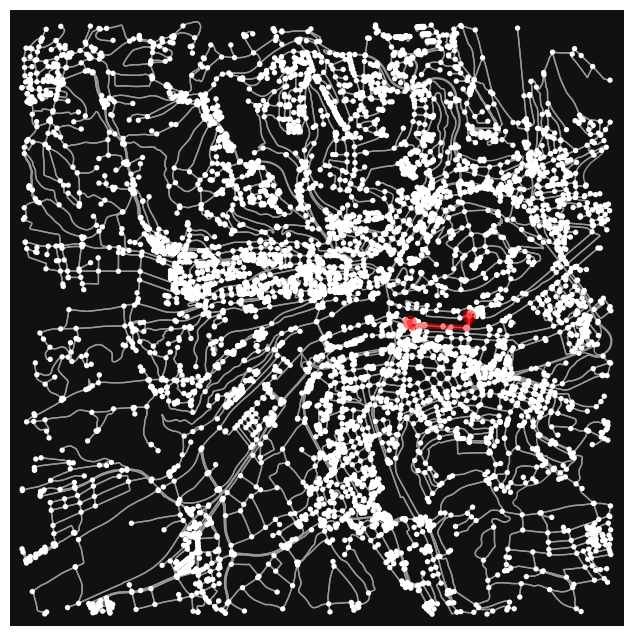

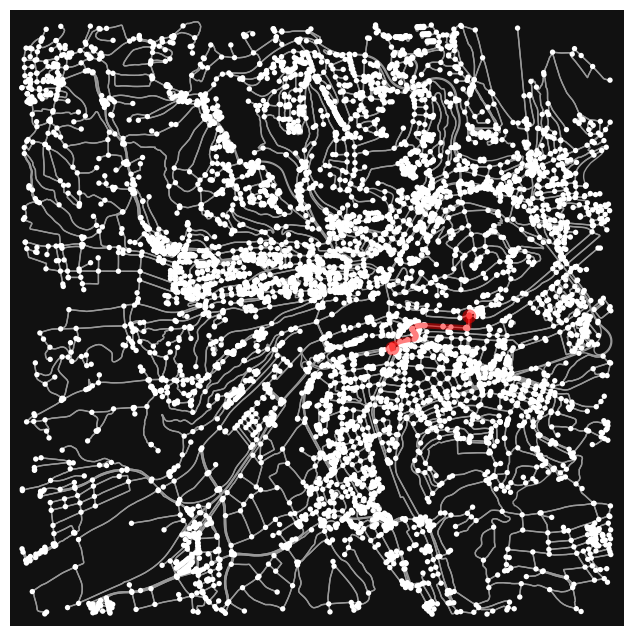

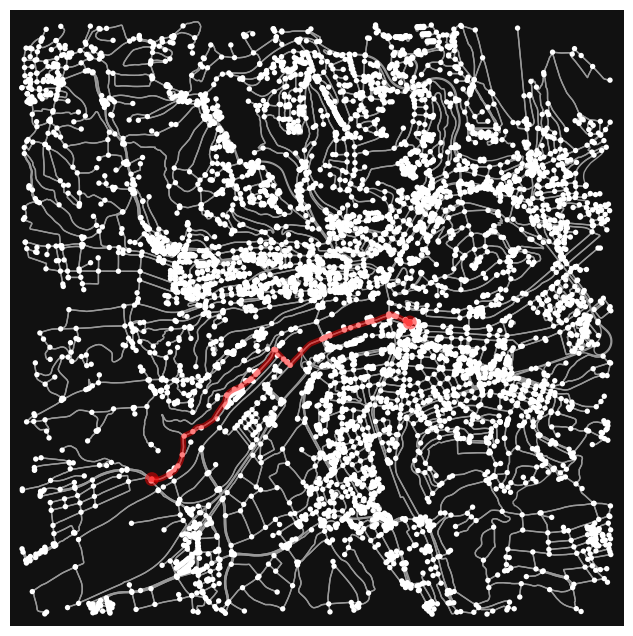

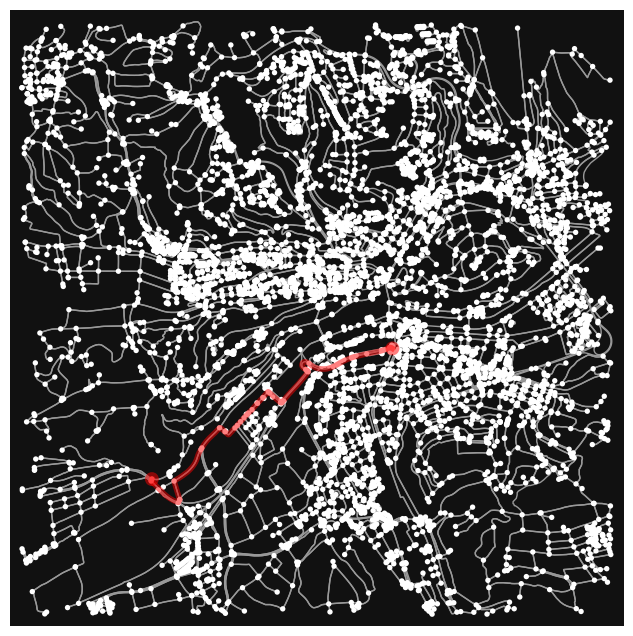

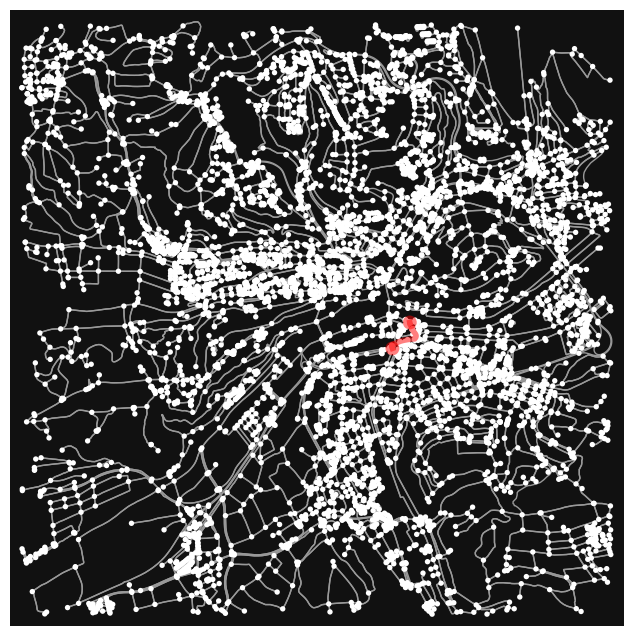

In [ ]:
# we can also show the shortest path in a plot
route_uv = nx.shortest_path(G, u, v, weight='length')
route_uw = nx.shortest_path(G, u, w, weight='length')
route_ux = nx.shortest_path(G, u, x, weight='length')
route_uy = nx.shortest_path(G, u, y, weight='length')
route_vw = nx.shortest_path(G, v, w, weight='length')
route_vx = nx.shortest_path(G, v, x, weight='length')
route_vy = nx.shortest_path(G, v, y, weight='length')
route_wx = nx.shortest_path(G, w, x, weight='length')
route_wy = nx.shortest_path(G, w, y, weight='length')
route_xy = nx.shortest_path(G, x, y, weight='length')

ox.plot_graph_route(G, route_uv)
ox.plot_graph_route(G, route_uw)
ox.plot_graph_route(G, route_ux)
ox.plot_graph_route(G, route_uy)
ox.plot_graph_route(G, route_vw)
ox.plot_graph_route(G, route_vx)
ox.plot_graph_route(G, route_vy)
ox.plot_graph_route(G, route_wx)
ox.plot_graph_route(G, route_wy)
ox.plot_graph_route(G, route_xy)
plt.show()

TypeError: shortest_path() got multiple values for argument 'weight'